In [1]:
!pip install ultralytics easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 28.5 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:

model = YOLO('plate_detection_best.pt')



0: 224x320 1 license_plate, 130.1ms
Speed: 2.4ms preprocess, 130.1ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Detected 1 license plates.
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteBounding box: x=96, y=258, w=100.88899993896484, h=24.99896240234375
Cropped license plate region: (24, 100, 3)


Detected text: DL49 AK49


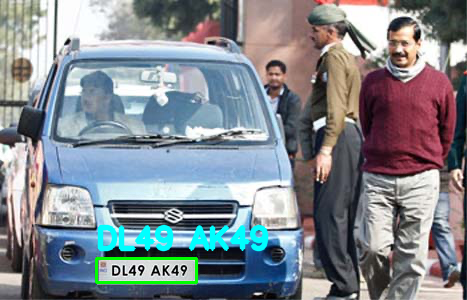

In [10]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import easyocr
from ultralytics import YOLO

def process_and_display_image(image_path, model):
    image = cv2.imread(image_path)
    if image is None or image.size == 0:
        raise ValueError(f"Failed to load image from {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform inference with the YOLO model
    results = model(image_rgb)  # Use the `model` directly

    # Now we can work with the results and extract bounding boxes
    boxes = results[0].boxes.xywh.cpu().numpy()  # Shape: (N, 4) where N is the number of boxes
    confidences = results[0].boxes.conf.cpu().numpy()  # Confidence scores for each box

    print(f"Detected {len(boxes)} license plates.")

    # Initialize EasyOCR reader (for OCR on cropped plates)
    ocr_reader = easyocr.Reader(['en'])

    # Loop through detected boxes (usually for license plate)
    for box, confidence in zip(boxes, confidences):
        x_center, y_center, w, h = box
        x1 = int(x_center - (w // 2))
        y1 = int(y_center - (h // 2))
        x2 = int(x_center + (w // 2))
        y2 = int(y_center + (h // 2))

        # Print the coordinates of the bounding box
        print(f"Bounding box: x={x1}, y={y1}, w={w}, h={h}")

        # Make sure the coordinates are within image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)

        # Draw the bounding box on the original image to inspect
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Crop the license plate area from the image
        plate_region = image[y1:y2, x1:x2]

        # Debug: Show the cropped license plate region
        print(f"Cropped license plate region: {plate_region.shape}")
        cv2_imshow(plate_region)  # This will show the region of the license plate
        cv2.waitKey(0)

        # Apply OCR on the cropped plate region
        ocr_text = ocr_reader.readtext(plate_region)

        # Print detected OCR text for debugging
        if len(ocr_text) == 0:
            print("No text detected.")
        else:
            for ocr_item in ocr_text:
                text = ocr_item[1]
                print(f"Detected text: {text}")

                # Draw the bounding box and text on the original image
                cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3, lineType=cv2.LINE_AA)

    # Display the final annotated image using OpenCV's imshow (Colab compatible)
    cv2_imshow(image)  # Use cv2_imshow instead of cv2.imshow()
    cv2.waitKey(0)  # Wait for user input to close the window
    cv2.destroyAllWindows()

# Example usage
image_path = 'Cars152.png'  # Replace with your image path
# Assuming your model is already loaded as the 'model' variable
process_and_display_image(image_path, model)
